In [1]:
# Import packages
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from firedrake.meshadapt import *
import ufl
import numpy as np
from firedrake import UnitSquareMesh,FunctionSpace,VectorFunctionSpace,SpatialCoordinate,pi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test for a simple Equation
First, start from simple case: 

$
-\nabla^2 u + u  = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma,
$

with:

$
f(x, y) = (1.0 + 8.0\pi^2)\cos(2\pi x)\cos(2\pi y).
$

This conveniently yields the analytical solution:

$
u(x, y) = \cos(2\pi x)\cos(2\pi y).
$

In [2]:
# Define class for L2 projector
class L2Projector:
    def __init__(self, mesh, P1_vec, phi_old,**kwargs):
        self.mesh = mesh
        self.P1_vec = P1_vec
        self.phi_old = phi_old
        self.dim = mesh.geometric_dimension()
        self._grad_phi = Function(P1_vec)

        # Measures
        degree = kwargs.get('quadrature_degree')
        self.dx = dx(domain=mesh, degree=degree)
        self.ds = ds(domain=mesh, degree=degree)
        self.dS = dS(domain=mesh, degree=degree)
        self.fix_boundary_nodes = kwargs.pop('fix_boundary_nodes', False)

    # Include the l2_projector code you provided
    @property
    def l2_projector(self):
        if hasattr(self, '_l2_projector'):
            return self._l2_projector
        u_cts = TrialFunction(self.P1_vec)
        v_cts = TestFunction(self.P1_vec)
        n = FacetNormal(self.mesh)

        # Domain interior
        phi_grad_v_dx = self.phi_old*dot(v_cts, n)*self.ds-ufl.inner(self.phi_old, ufl.div(v_cts))*self.dx
        a = ufl.inner(v_cts, u_cts)*self.dx
        L = phi_grad_v_dx

        # Enforce no movement normal to boundary
        n = ufl.FacetNormal(self.mesh)
        bcs = []
        for i in self.mesh.exterior_facets.unique_markers:
            if self.fix_boundary_nodes:
                bcs.append(DirichletBC(self.P1_vec, 0, i))
                continue

            # Check for axis-aligned boundaries
            _n = [assemble(abs(n[j])*self.ds(i)) for j in range(self.dim)]
            if np.allclose(_n, 0.0):
                raise ValueError(f"Invalid normal vector {_n}")
            else:
                if np.isclose(_n[0], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(1), 0, i))
                    continue
                elif np.isclose(_n[1], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(0), 0, i))
                    continue

            a_bc = ufl.dot(v_cts, n)*ufl.dot(u_cts, n)*self.ds
            bcs.append(EquationBC(a_bc == 0, self._grad_phi, i))

            s = ufl.perp(n)
            a_bc = ufl.dot(v_cts, s)*ufl.dot(u_cts, s)*self.ds
            L_bc = ufl.dot(v_cts, s)*phi_grad_v_dx
            bcs.append(EquationBC(a_bc == L_bc, self._grad_phi, i))

        # Create solver
        problem = LinearVariationalProblem(a, L, self._grad_phi, bcs=None)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._l2_projector = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._l2_projector


In [47]:
u_grad_diffs = []
u_grad_exacts = []
u_grad_l2s = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 1)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)
    u_grad_exacts.append(u_grad_exact)
    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()
    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    u_grad_l2s.append(u_grad_l2)
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print(f"The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs.append(u_grad_diff)

The global error is 0.80062785 for 10x10 Mesh
The global error is 0.22879336 for 20x20 Mesh
The global error is 0.10791515 for 30x30 Mesh
The global error is 0.06348304 for 40x40 Mesh
The global error is 0.04222385 for 50x50 Mesh
The global error is 0.03035615 for 60x60 Mesh
The global error is 0.02302461 for 70x70 Mesh
The global error is 0.01815872 for 80x80 Mesh
The global error is 0.01475210 for 90x90 Mesh
The global error is 0.01226656 for 100x100 Mesh


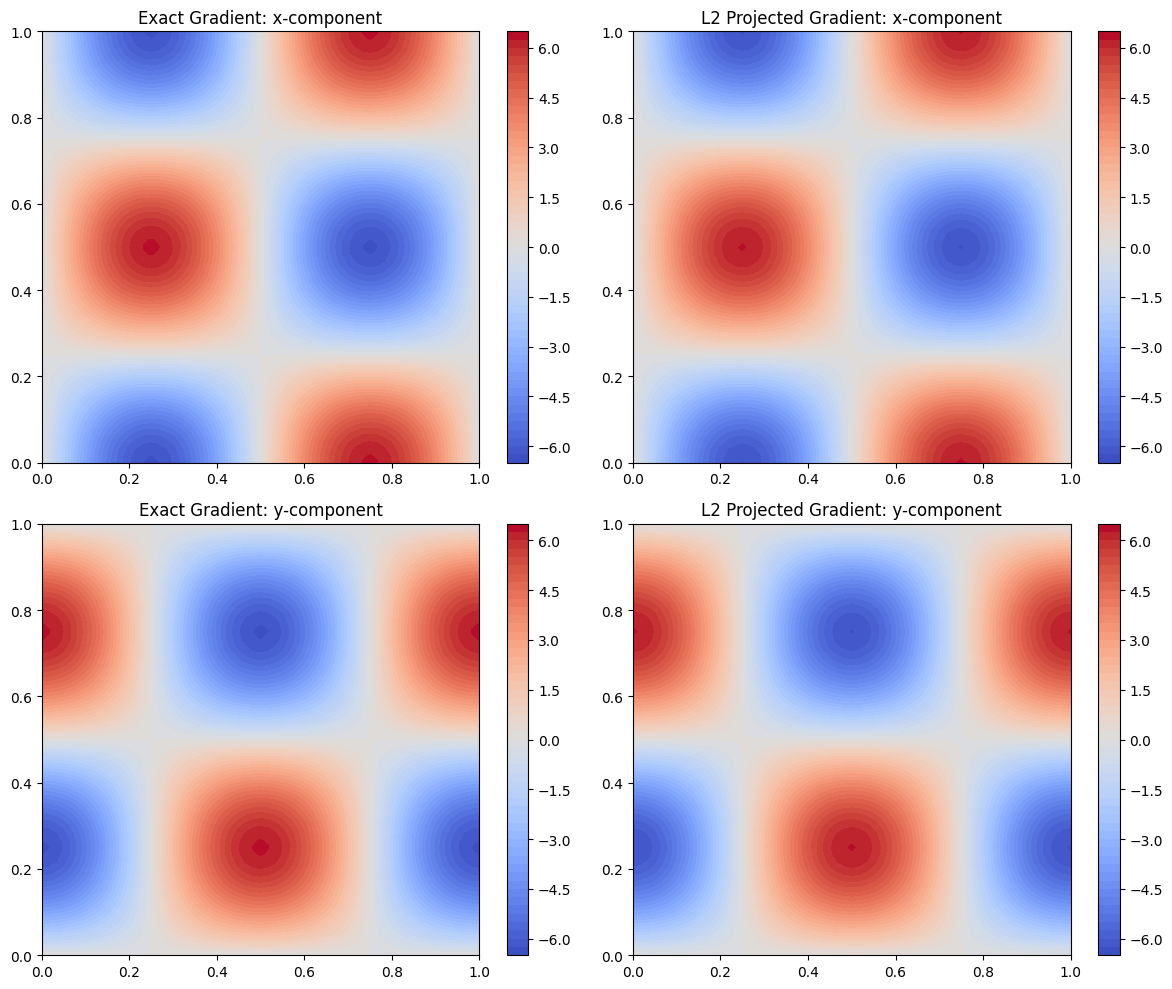

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the x-component of the exact gradient
axes[0,0].set_title("Exact Gradient: x-component")
contour = tricontourf(u_grad_exacts[5].sub(0), axes=axes[0,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])

# Plot the x-component of the L2 projected gradient
axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2s[5].sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])

# Plot the x-component of the exact gradient
axes[1,0].set_title("Exact Gradient: y-component")
contour = tricontourf(u_grad_exacts[5].sub(1), axes=axes[1,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])

# Plot the x-component of the L2 projected gradient
axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2s[5].sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

Try with CG2

In [49]:
u_grad_diffs_cg2 = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 2)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 2)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs_cg2.append(u_grad_diff)

The global error is 0.11468764 for 10x10 Mesh
The global error is 0.03380758 for 20x20 Mesh
The global error is 0.01563092 for 30x30 Mesh
The global error is 0.00892670 for 40x40 Mesh
The global error is 0.00575568 for 50x50 Mesh
The global error is 0.00401387 for 60x60 Mesh
The global error is 0.00295674 for 70x70 Mesh
The global error is 0.00226775 for 80x80 Mesh
The global error is 0.00179404 for 90x90 Mesh
The global error is 0.00145450 for 100x100 Mesh


In [50]:
u_grad_diffs_cg3 = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 3)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 3)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs_cg3.append(u_grad_diff)

The global error is 0.00867463 for 10x10 Mesh
The global error is 0.00095600 for 20x20 Mesh
The global error is 0.00027246 for 30x30 Mesh
The global error is 0.00011294 for 40x40 Mesh
The global error is 0.00005726 for 50x50 Mesh
The global error is 0.00003293 for 60x60 Mesh
The global error is 0.00002065 for 70x70 Mesh
The global error is 0.00001379 for 80x80 Mesh
The global error is 0.00000966 for 90x90 Mesh
The global error is 0.00000703 for 100x100 Mesh


In [51]:
u_grad_diffs_cg4 = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 4)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 4)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs_cg4.append(u_grad_diff)

The global error is 0.00073309 for 10x10 Mesh
The global error is 0.00004958 for 20x20 Mesh
The global error is 0.00000998 for 30x30 Mesh
The global error is 0.00000326 for 40x40 Mesh
The global error is 0.00000139 for 50x50 Mesh
The global error is 0.00000074 for 60x60 Mesh
The global error is 0.00000047 for 70x70 Mesh
The global error is 0.00000035 for 80x80 Mesh
The global error is 0.00000029 for 90x90 Mesh
The global error is 0.00000026 for 100x100 Mesh


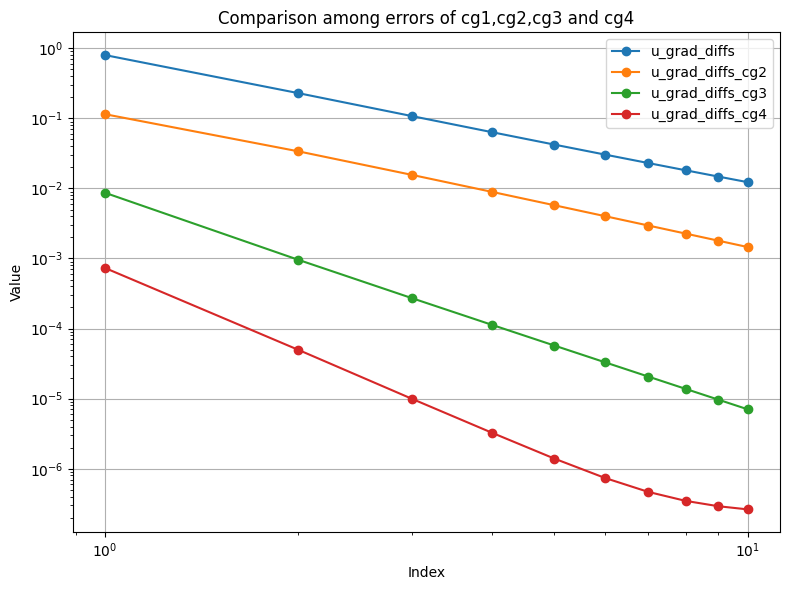

In [52]:
# Plotting
# Assuming linear spacing for nodes/elements
elements = np.linspace(1, 10, 10)
plt.figure(figsize=(8, 6))

plt.plot(elements, u_grad_diffs, '-o', label="u_grad_diffs")
plt.plot(elements, u_grad_diffs_cg2, '-o', label="u_grad_diffs_cg2")
plt.plot(elements, u_grad_diffs_cg3, '-o', label="u_grad_diffs_cg3")
plt.plot(elements, u_grad_diffs_cg4, '-o', label="u_grad_diffs_cg4")

# Adding title and labels
plt.title("Comparison among errors of cg1,cg2,cg3 and cg4")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.yscale("log")  # if you want a logarithmic scale for residuals
plt.xscale("log")
# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

For CG1: log(e(h)) = -1.8199132168187102 * log(h) + 3.9656512650317985
For CG2: log(e(h)) = -1.911500380188389 * log(h) + 2.3011611490730535
For CG3: log(e(h)) = -3.0820872200285527 * log(h) + 2.3042019760118686
For CG4: log(e(h)) = -3.544874414266531 * log(h) + 0.6629057965066893


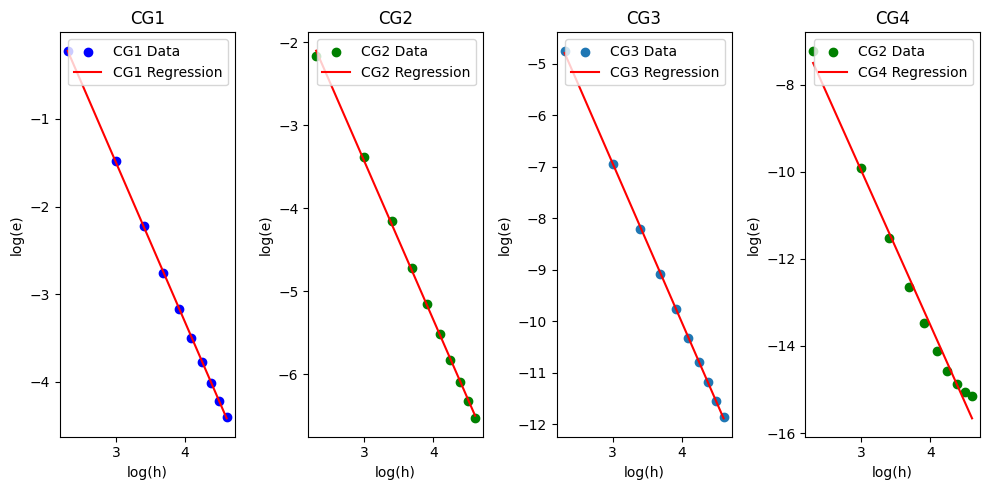

In [58]:
# Sample data (replace this with your actual data)
mesh_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Taking logarithm of the data
log_mesh_sizes_cg1 = np.log(mesh_sizes)
log_errors_cg1 = np.log(u_grad_diffs)

log_mesh_sizes_cg2 = np.log(mesh_sizes)
log_errors_cg2 = np.log(u_grad_diffs_cg2)

log_mesh_sizes_cg3 = np.log(mesh_sizes)
log_errors_cg3 = np.log(u_grad_diffs_cg3)

log_mesh_sizes_cg4 = np.log(mesh_sizes)
log_errors_cg4 = np.log(u_grad_diffs_cg4)

# Polynomial fit of degree 1 (linear regression)
coefficients_cg1 = np.polyfit(log_mesh_sizes_cg1, log_errors_cg1, 1)
coefficients_cg2 = np.polyfit(log_mesh_sizes_cg2, log_errors_cg2, 1)
coefficients_cg3 = np.polyfit(log_mesh_sizes_cg3, log_errors_cg3, 1)
coefficients_cg4 = np.polyfit(log_mesh_sizes_cg4, log_errors_cg4, 1)

# Print the derived expressions
print(f"For CG1: log(e(h)) = {coefficients_cg1[0]} * log(h) + {coefficients_cg1[1]}")
print(f"For CG2: log(e(h)) = {coefficients_cg2[0]} * log(h) + {coefficients_cg2[1]}")
print(f"For CG3: log(e(h)) = {coefficients_cg3[0]} * log(h) + {coefficients_cg3[1]}")
print(f"For CG4: log(e(h)) = {coefficients_cg4[0]} * log(h) + {coefficients_cg4[1]}")

# Visualize the data and the linear regression
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.scatter(log_mesh_sizes_cg1, log_errors_cg1, color='blue', label='CG1 Data')
plt.plot(log_mesh_sizes_cg1, coefficients_cg1[0] * log_mesh_sizes_cg1 + coefficients_cg1[1], color='red', label='CG1 Regression')
plt.title("CG1")
plt.xlabel("log(h)")
plt.ylabel("log(e)")
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(log_mesh_sizes_cg2, log_errors_cg2, color='green', label='CG2 Data')
plt.plot(log_mesh_sizes_cg2, coefficients_cg2[0] * log_mesh_sizes_cg2 + coefficients_cg2[1], color='red', label='CG2 Regression')
plt.title("CG2")
plt.xlabel("log(h)")
plt.ylabel("log(e)")
plt.legend()

plt.subplot(1, 4, 3)
plt.scatter(log_mesh_sizes_cg3, log_errors_cg3, label='CG3 Data')
plt.plot(log_mesh_sizes_cg3, coefficients_cg3[0] * log_mesh_sizes_cg3 + coefficients_cg3[1], color='red', label='CG3 Regression')
plt.title("CG3")
plt.xlabel("log(h)")
plt.ylabel("log(e)")
plt.legend()

plt.subplot(1, 4, 4)
plt.scatter(log_mesh_sizes_cg4, log_errors_cg4, color='green', label='CG2 Data')
plt.plot(log_mesh_sizes_cg4, coefficients_cg4[0] * log_mesh_sizes_cg4 + coefficients_cg4[1], color='red', label='CG4 Regression')
plt.title("CG4")
plt.xlabel("log(h)")
plt.ylabel("log(e)")
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
u_grad_exacts = []
u_grad_l2s = []

for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 4)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 4)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact_ = Function(P1).interpolate(x*(1-x)*y*(1-y)*exp(x+y)*sin(2*pi*x*y))
    # Calculate analytical gradient of u
    u_grad_exact_expr_ = as_vector([(y-1)*y*exp(x+y)*((x**2+x-1)*sin(2*pi*x*y)+2*pi*(x-1)*x*y*cos(2*pi*x*y)),
                                    (x-1)*x*exp(x+y)*((y**2+y-1)*sin(2*pi*x*y)+2*pi*(y-1)*x*y*cos(2*pi*x*y))])
    u_grad_exact = project(u_grad_exact_expr_, P1_vec)
    u_grad_exacts.append(u_grad_exact)
    
    laplacian_u_exact = -(
        x*(x - 1)*(
            -4*pi**2*x**2*y*(y - 1)*sin(2*pi*x*y) 
            + 4*pi*x*y*(y - 1)*cos(2*pi*x*y) 
            + 4*pi*x*y*cos(2*pi*x*y) 
            + 4*pi*x*(y - 1)*cos(2*pi*x*y) 
            + y*(y - 1)*sin(2*pi*x*y) 
            + 2*y*sin(2*pi*x*y) 
            + 2*(y - 1)*sin(2*pi*x*y) 
            + 2*sin(2*pi*x*y)
        )*exp(x + y) 
        + y*(y - 1)*(
            -4*pi**2*x*y**2*(x - 1)*sin(2*pi*x*y) 
            + 4*pi*x*y*(x - 1)*cos(2*pi*x*y) 
            + 4*pi*x*y*cos(2*pi*x*y) 
            + x*(x - 1)*sin(2*pi*x*y) 
            + 2*x*sin(2*pi*x*y) 
            + 4*pi*y*(x - 1)*cos(2*pi*x*y) 
            + 2*(x - 1)*sin(2*pi*x*y) 
            + 2*sin(2*pi*x*y)
        )*exp(x + y)
    )

    # Interpolating the Laplacian to the function space (assuming you've defined P1 before):
    f= Function(P1).interpolate(laplacian_u_exact)
    bc = DirichletBC(P1, Constant(0.0), "on_boundary")

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol, bcs =bc)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi

    
    u_grad_l2s.append(u_grad_l2)
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.10f" % (u_grad_diff))

The global error is 0.0000482949
The global error is 0.0000030861
The global error is 0.0000006146
The global error is 0.0000001977
The global error is 0.0000000851
The global error is 0.0000000464
The global error is 0.0000000316
The global error is 0.0000000256
The global error is 0.0000000230
The global error is 0.0000000216


For CG3: log(e(h)) = -3.453733649032663 * log(h) + -2.3828353704425016


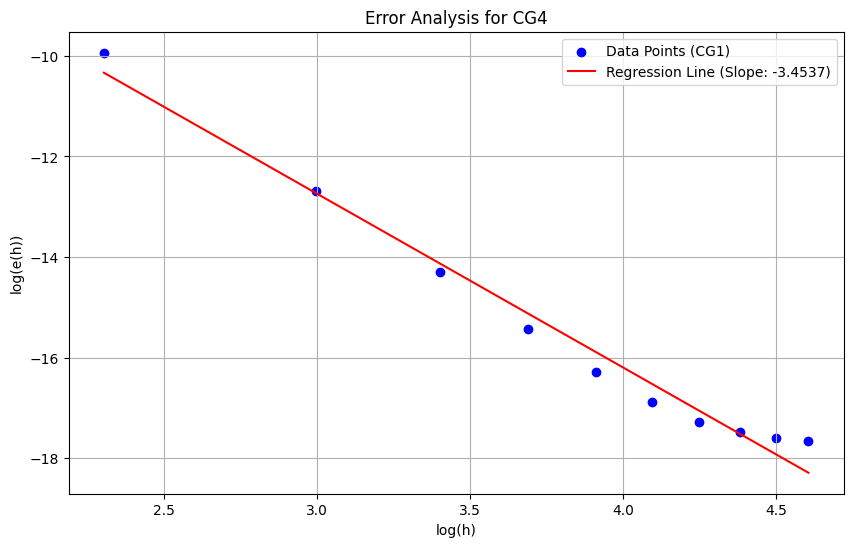

In [55]:
from scipy.stats import linregress

# Given data for CG1
mesh_sizes = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])


# Compute log-log values
log_mesh_sizes = np.log(mesh_sizes)
log_errors = np.log(u_grad_l2s)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_mesh_sizes, log_errors)

print(f"For CG3: log(e(h)) = {slope} * log(h) + {intercept}")

# Visualize the regression
plt.figure(figsize=(10,6))
plt.scatter(log_mesh_sizes, log_errors, color='blue', label='Data Points (CG1)')
plt.plot(log_mesh_sizes, slope*log_mesh_sizes + intercept, color='red', label=f'Regression Line (Slope: {slope:.4f})')
plt.xlabel('log(h)')
plt.ylabel('log(e(h))')
plt.title('Error Analysis for CG4')
plt.legend()
plt.grid(True)
plt.show()


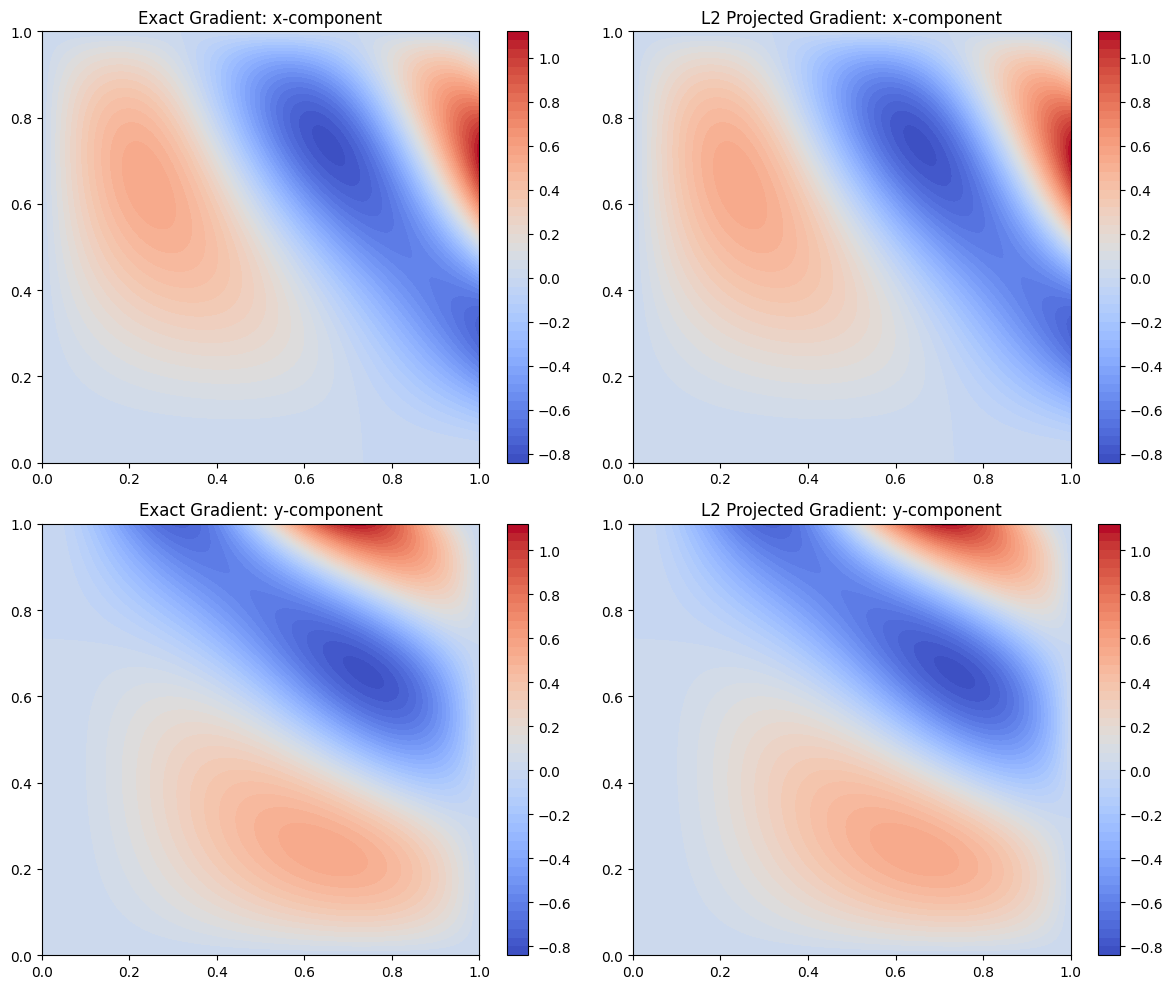

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the x-component of the exact gradient
axes[0,0].set_title("Exact Gradient: x-component")
contour = tricontourf(u_grad_exacts[9].sub(0), axes=axes[0,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])

# Plot the x-component of the L2 projected gradient
axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2s[9].sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])

# Plot the x-component of the exact gradient
axes[1,0].set_title("Exact Gradient: y-component")
contour = tricontourf(u_grad_exacts[9].sub(1), axes=axes[1,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])

# Plot the x-component of the L2 projected gradient
axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2s[9].sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

L2 projection seems to be a powerful tool!

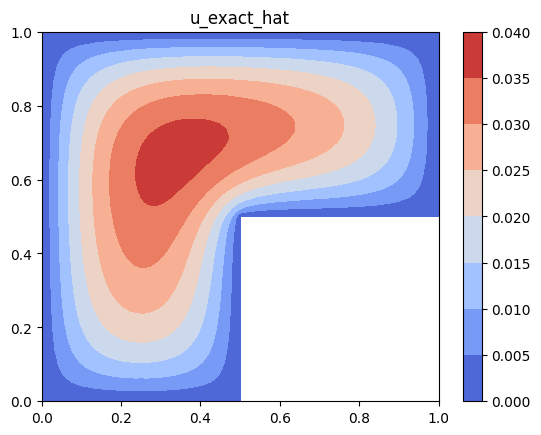

In [81]:
mesh_highres = Mesh("lshape.msh")
P1_highres = FunctionSpace(mesh_highres, 'CG', 6)
P1_vec_highres = VectorFunctionSpace(mesh_highres, 'CG', 6)
x, y = SpatialCoordinate(mesh_highres)
v = TestFunction(P1_highres)
u_highres = Function(P1_highres)

f = Function(P1_highres).interpolate(Constant(1))
bc = DirichletBC(P1_highres, Constant(0.0), "on_boundary")

F = (dot(grad(u_highres), grad(v)) - inner(f, v)) * dx
solve(F == 0, u_highres, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bc)

fig, axes = plt.subplots()
u_plt = tricontourf(u_highres, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_exact_hat")
plt.show()

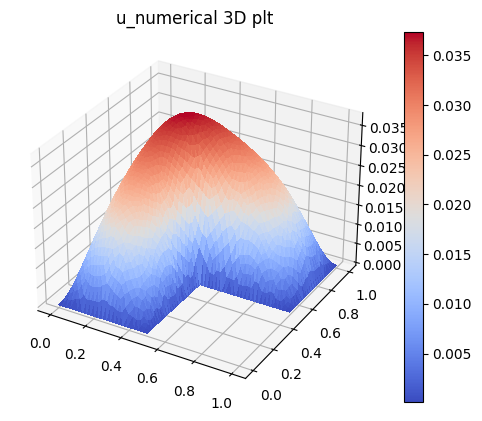

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u_exact_plt = trisurf(u_highres, axes=ax, cmap='coolwarm')
fig.colorbar(u_exact_plt,ax = ax)
plt.title("u_numerical 3D plt")
plt.show()

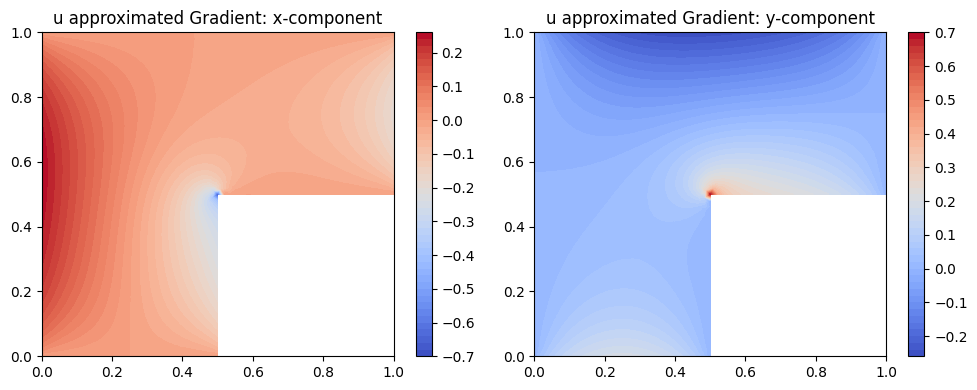

In [83]:
u_highres_grad = grad(u_highres)
u_highres_grad_projected = project(u_highres_grad, P1_vec_highres)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the x-component of the L2 projected gradient
axes[0].set_title("u approximated Gradient: x-component")
contour = tricontourf(u_highres_grad_projected.sub(0), axes=axes[0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0])

axes[1].set_title("u approximated Gradient: y-component")
contour = tricontourf(u_highres_grad_projected.sub(1), axes=axes[1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1])

plt.tight_layout()
plt.show()


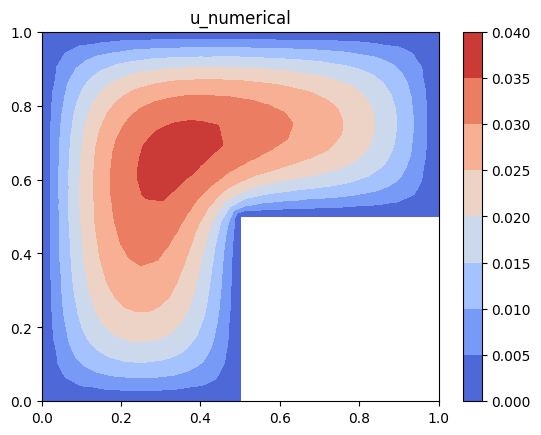

In [67]:
mesh = Mesh("lshape.msh")
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)
x, y = SpatialCoordinate(mesh)
v = TestFunction(P1)
u = Function(P1)

f = Function(P1).interpolate(Constant(1))
bc = DirichletBC(P1, Constant(0.0), "on_boundary")

F = (dot(grad(u), grad(v)) - inner(f, v)) * dx
solve(F == 0, u, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bc)

fig, axes = plt.subplots()
u_plt = tricontourf(u, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_numerical")
plt.show()

In [68]:
# Use the solution of the Poisson equation as phi_old
projector = L2Projector(mesh, P1_vec, u) #TODO: replace u_exact with u_sol? Boundary?

# Call L2 projector and get result
l2_projector = projector.l2_projector
l2_projector.solve()

# Compare L2 projected gradient with analytical gradient
u_grad_l2 = projector._grad_phi

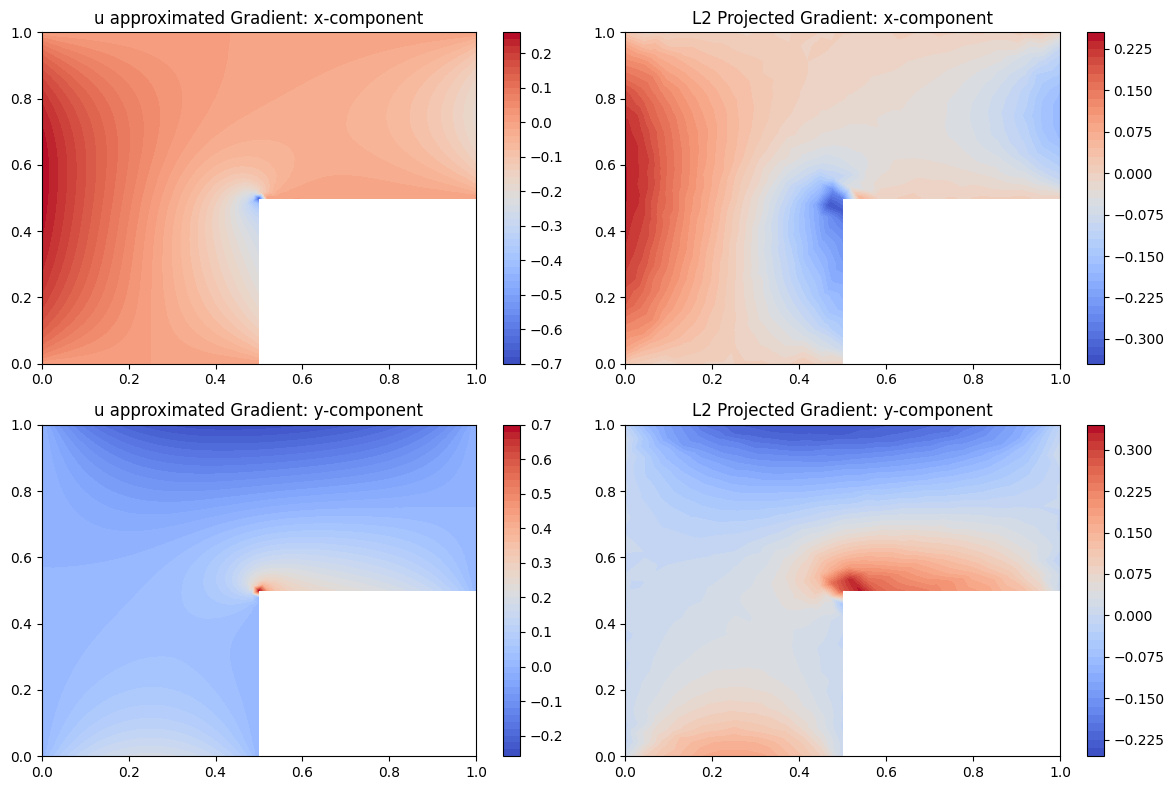

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


axes[0,0].set_title("u approximated Gradient: x-component")
contour = tricontourf(u_highres_grad_projected.sub(0), axes=axes[0,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])


axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2.sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])


axes[1,0].set_title("u approximated Gradient: y-component")
contour = tricontourf(u_highres_grad_projected.sub(1), axes=axes[1,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])



axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2.sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [86]:
#grad_highres_on_fine_mesh = interpolate(u_highres_grad, P1_vec_fine)
grad_projected_on_fine_mesh = project(u_highres_grad_projected, P1_vec)


#  Compute the magnitudes of the gradients
u_grad_diff = errornorm(grad_projected_on_fine_mesh,u_grad_l2)
print("The global error is %.8f" % (u_grad_diff) )

The global error is 0.00452954


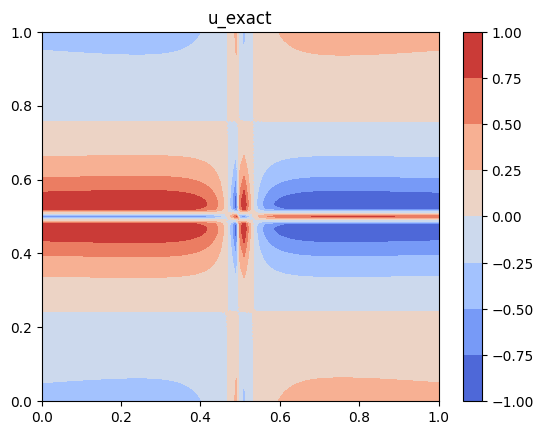

In [6]:
# Create a mesh and define function spaces
mesh = UnitSquareMesh(100, 100)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)
x, y = SpatialCoordinate(mesh)

epsilon = 1e-10
# Compute the analytical gradient
u_exact = Function(P1).interpolate(sin(pow(x-0.5+epsilon, -1./3.))*cos(pow(y-0.5+epsilon, -1./3.)))
fig, axes = plt.subplots()
u_plt = tricontourf(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_exact")
plt.show()

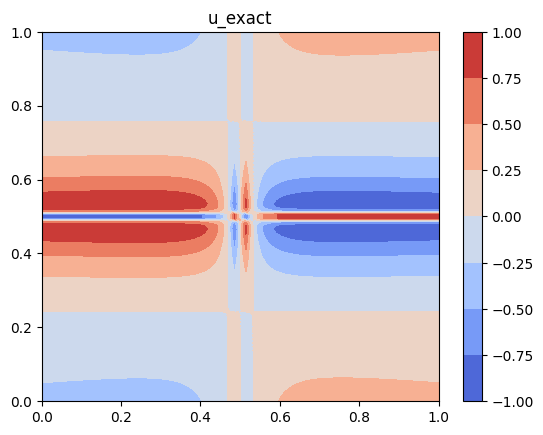

In [53]:
# Create a mesh and define function spaces
mesh = UnitSquareMesh(103, 103)  # Using an odd number to skip (0.5, 0.5)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)
x, y = SpatialCoordinate(mesh)

# Compute the analytical function
u_exact = Function(P1).interpolate(sin(pow(x-0.5, -1./3.))*cos(pow(y-0.5, -1./3.)))
# Calculate analytical gradient of u
u_grad_exact_expr = as_vector([-(1/3)*cos((x - 0.5)**(-1/3))*cos((y - 0.5)**(-1/3))/(x - 0.5)**(4/3),
                                (1/3)*sin((x - 0.5)**(-1/3))*sin((y - 0.5)**(-1/3))/(y - 0.5)**(4/3)])

u_grad_exact = project(u_grad_exact_expr, P1_vec)

fig, axes = plt.subplots()
u_plt = tricontourf(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_exact")
plt.show()


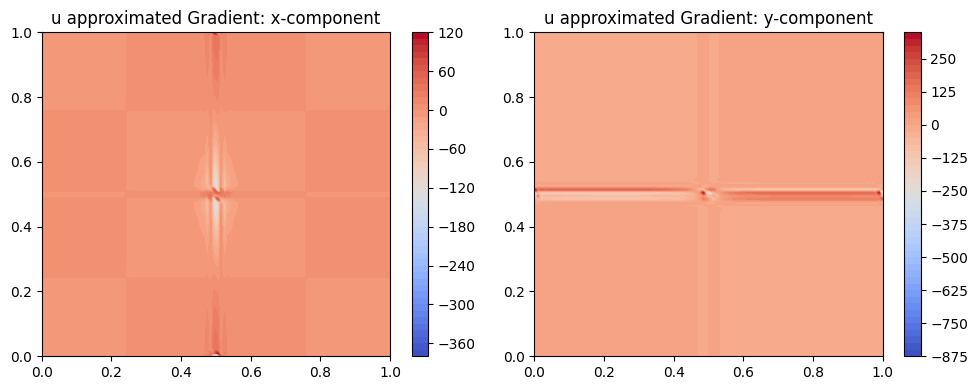

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the x-component of the L2 projected gradient
axes[0].set_title("u approximated Gradient: x-component")
contour = tricontourf(u_grad_exact.sub(0), axes=axes[0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0])

axes[1].set_title("u approximated Gradient: y-component")
contour = tricontourf(u_grad_exact.sub(1), axes=axes[1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1])

plt.tight_layout()
plt.show()

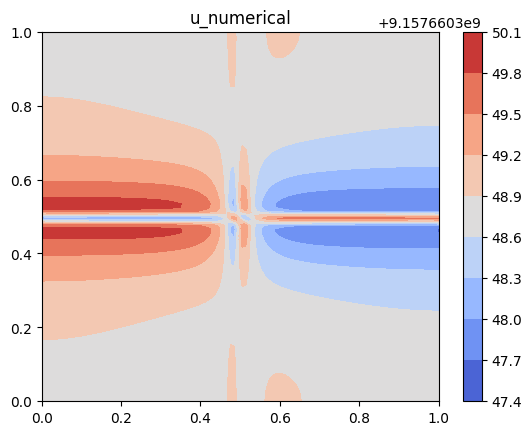

In [55]:
u_grad = grad(u_exact)
u_grad_projected = project(u_grad, P1_vec)
u = TrialFunction(P1)
v = TestFunction(P1)
# Compute the right-hand side f by taking the Laplacian of u_exact
f = Function(P1).interpolate(-div(u_grad_projected))

# Define the variational problem
u = TrialFunction(P1)
v = TestFunction(P1)
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

# Set Dirichlet boundary condition using u_exact
bc = DirichletBC(P1, u_exact, "on_boundary")

# Solve the PDE
u_sol = Function(P1)
solve(a == L, u_sol, bcs=bc)

# Compute solution for Poisson equation
u_sol = Function(P1)
solve(a == L, u_sol)
v = TestFunction(P1)

fig, axes = plt.subplots()
u_plt = tricontourf(u_sol, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_numerical")
plt.show() 

In [56]:
# Use the solution of the Poisson equation as phi_old
projector = L2Projector(mesh, P1_vec, u_exact) #TODO: replace u_exact with u_sol? Boundary?

# Call L2 projector and get result
l2_projector = projector.l2_projector
l2_projector.solve()

# Compare L2 projected gradient with analytical gradient
u_grad_l2 = projector._grad_phi

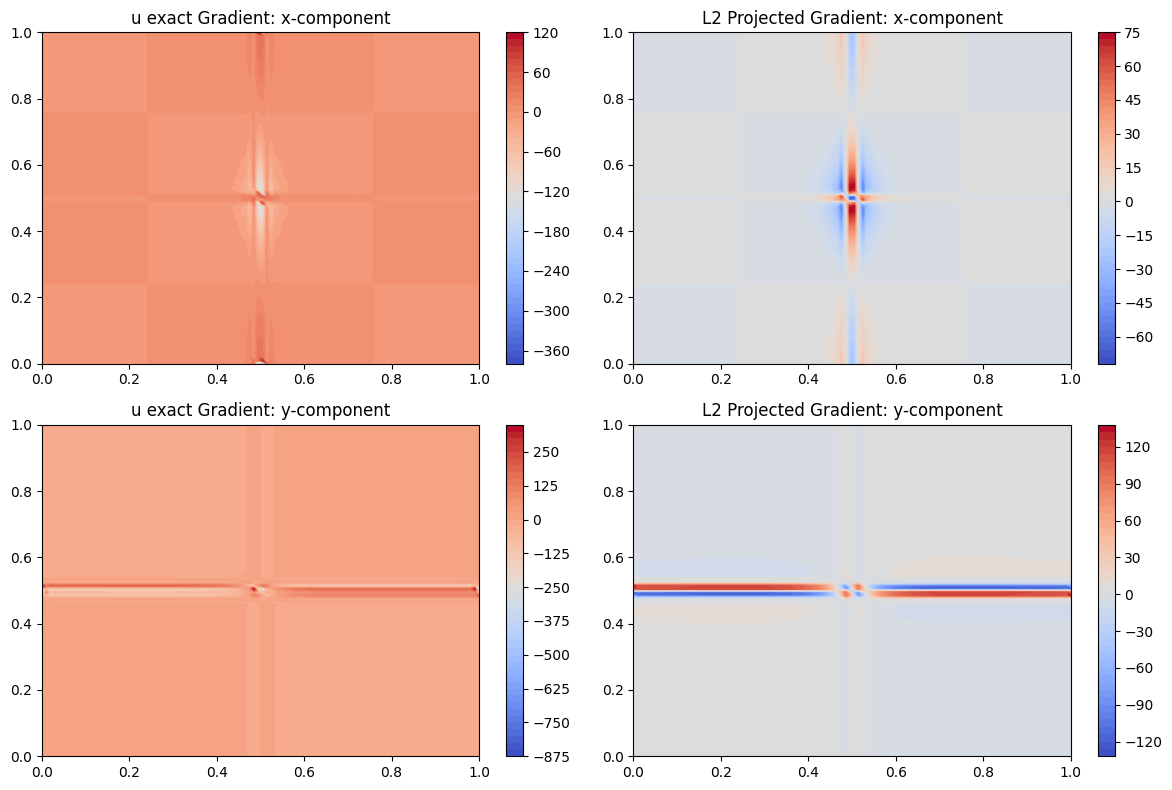

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


axes[0,0].set_title("u exact Gradient: x-component")
contour = tricontourf(u_grad_exact.sub(0), axes=axes[0,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])


axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2.sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])


axes[1,0].set_title("u exact Gradient: y-component")
contour = tricontourf(u_grad_exact.sub(1), axes=axes[1,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])



axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2.sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [58]:
u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
print("The global error is %.10f" % (u_grad_diff))

The global error is 23.0958177283
